# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [1438]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.modules.game import Game
from src.helpers.create_q_dict import init_q
from src.helpers.runner import play_n_games, play_round
from src.helpers.evaluation import cummulative_rewards_per_round
from src.modules.train import Trainer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
    - Always take the best action. In my code, it"s equivalent to setting epsilon to -1
- Epsilon-Greedy Algorithm
    - With probability=epsilon, randomly take action. Otherwise, take best action
    - I allow epsilon to decay through learning. Meaning, Always explore at first, then start to exploit more.
- Thompson Sampling methods.
    - In my situation, this is handled by setting always_random=True
    - The probability of an action is chosen according to the learned Q value distribution over actions.
    - I normalize Q values by taking softmax of Q values.


I find that always_random=True leads to faster training than in epsilon decay.

I store "bestQ" at each interval of evaluation (expensive function, since I simulate 1000 rounds to evaluate).
So, Backtracking will be performed until number of rounds is complete.

#### Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [1439]:
rules = {
    "dealer_hit_soft17": True,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}


### I'll learn according to standard rules of play. I can evaluate by tweaking rules to observe house edge for both.

In [1573]:
eps_decay = .000004
eps_min = .1

n_rounds_evaluate = 50
n_games_evaluate = 200

n_episodes = 3_000_000
gamma = .95
lr = .005
every = 50_000
method = "thompson" # "thompson" or "epsilon"


n_players = 1 # number of players
wagers = [1]*n_players # wagers per player "units"

trainer = Trainer(
    early_stop=False,
    method=method,
    lr=lr,
    gamma=gamma,
    eps_decay=eps_decay,
    eps_min=eps_min,
    leniency=20
)

blackjack = Game(**game_hyperparams)

eps = None
for r in range(n_episodes):
    if method == "epsilon":
        eps = max(eps_min, np.exp(-eps_decay * r))
    trainer.step(
        blackjack=blackjack,
        wagers=wagers,
        eps=eps,
        reset_deck=True
    )
    if not r % every:
        reward, correctness = await trainer.evaluate(
            n_rounds=n_rounds_evaluate,
            n_games=n_games_evaluate,
            game_hyperparams=game_hyperparams
        )

        print(f"{r+1} of {n_episodes} -- Score : {reward:.6f} -- % Correct : {correctness:.6f} -- EPS : {eps or -1:.6f}")

        if trainer.stop:
            print("early stopping")
            break

bestQ = trainer.get_q(backtrack=False)

1 of 3000000 -- Score : -0.449600 -- % Correct : 0.328125 -- EPS : -1.000000
50001 of 3000000 -- Score : -0.040000 -- % Correct : 0.779412 -- EPS : -1.000000
100001 of 3000000 -- Score : -0.028700 -- % Correct : 0.808824 -- EPS : -1.000000
150001 of 3000000 -- Score : -0.008900 -- % Correct : 0.875000 -- EPS : -1.000000
200001 of 3000000 -- Score : -0.021100 -- % Correct : 0.847222 -- EPS : -1.000000
250001 of 3000000 -- Score : -0.037650 -- % Correct : 0.909091 -- EPS : -1.000000
300001 of 3000000 -- Score : -0.008350 -- % Correct : 0.924242 -- EPS : -1.000000
350001 of 3000000 -- Score : -0.010150 -- % Correct : 0.931507 -- EPS : -1.000000
400001 of 3000000 -- Score : -0.015100 -- % Correct : 0.943662 -- EPS : -1.000000
450001 of 3000000 -- Score : -0.003350 -- % Correct : 0.850000 -- EPS : -1.000000
500001 of 3000000 -- Score : -0.002100 -- % Correct : 0.906667 -- EPS : -1.000000
550001 of 3000000 -- Score : -0.025550 -- % Correct : 0.914634 -- EPS : -1.000000
600001 of 3000000 -- S

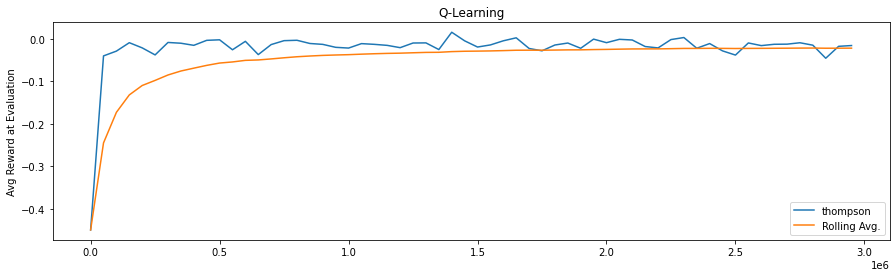

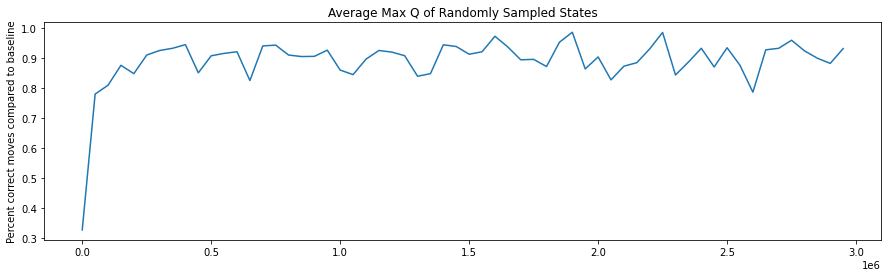

In [1574]:
plt.figure(figsize=(15,4))
plt.plot(
    np.arange(0,len(trainer.eval))*every,
    trainer.eval,
    label=method
)
plt.plot(
    np.arange(0,len(trainer.eval))*every,
    np.cumsum(trainer.eval) / np.arange(1,len(trainer.eval)+1),
    label="Rolling Avg."
)
# plt.vlines(x=np.argmax(trainer.eval)*every,ymin=min(trainer.eval),ymax=max(trainer.eval),color="k")
plt.title("Q-Learning")
plt.ylabel("Avg Reward at Evaluation")
plt.legend()
plt.show()


plt.figure(figsize=(15,4))
plt.title("Average Max Q of Randomly Sampled States")
plt.ylabel("Percent correct moves compared to baseline")
plt.plot(np.arange(0,len(trainer.eval))*every, trainer.correctness)
plt.show()

In [1586]:
np.save("./models/Q",bestQ)
Qlearned = np.load("./models/Q.npy",allow_pickle=True).item()

### Evaluate new policy, as well as a random one, and a simple one.

It is apparent that the learned policy performs better in practice than a random one, and a "simple" one. In the "simple" one, I create a basic strategy where the player hits until they have >17

In [1576]:
n_games = 2_500
n_rounds = 50

print("Generating Random Rewards...")
randQ = init_q()
rewards = await play_n_games(
    q=randQ,
    wagers=[1],
    n_rounds=50,
    n_games=2_500,
    game_hyperparams=game_hyperparams
)
random_rewards = cummulative_rewards_per_round(rewards)[:, 0]

print("Generating Learned Rewards...")
rewards = await play_n_games(
    q=Qlearned,
    wagers=[1],
    n_rounds=50,
    n_games=2_500,
    game_hyperparams=game_hyperparams
)
learned_rewards = cummulative_rewards_per_round(rewards)[:, 0]
    
print("Generating Accepted Rewards... (found online to be optimal play)")
accepted_q = init_q(mode="accepted")
rewards = await play_n_games(
    q=accepted_q,
    wagers=[1],
    n_rounds=50,
    n_games=2_500,
    game_hyperparams=game_hyperparams
)
accepted_rewards = cummulative_rewards_per_round(rewards)[:, 0]
    
print("Generating Meh Rewards...")
somewhat_smart_q = init_q(mode="house")
rewards = await play_n_games(
    q=somewhat_smart_q,
    wagers=[1],
    n_rounds=50,
    n_games=2_500,
    game_hyperparams=game_hyperparams
)
meh_rewards = cummulative_rewards_per_round(rewards)[:, 0]
print("Done")

Generating Random Rewards...
Generating Learned Rewards...
Generating Accepted Rewards... (found online to be optimal play)
Generating Meh Rewards...
Done


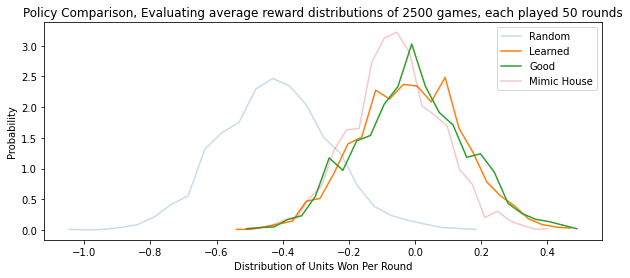

In [1577]:
plt.figure(figsize=(10,4))
plt.title(f"Policy Comparison, Evaluating average reward distributions of {n_games} games, each played {n_rounds} rounds")

a,b = np.histogram(random_rewards,bins=25, density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])],a, label="Random", alpha=.25)

a,b = np.histogram(learned_rewards,bins=25, density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])],a, label="Learned")

a,b = np.histogram(accepted_rewards,bins=25, density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])],a, label="Good")

a,b = np.histogram(meh_rewards,bins=25, density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])],a, label="Mimic House", alpha=.25)

plt.xlabel("Distribution of Units Won Per Round")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [1578]:
print("We can observe the Expected Value of Blackjack following these policies:")
print("This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)\n")
print("Play Randomly:")
print(f"\t{np.mean(random_rewards):.4f} units net per round\n")
print("Mimicing the House:")
print(f"\t{np.mean(meh_rewards):.4f} units net per round\n")
print("Following Accepted Policy:")
print(f"\t{np.mean(accepted_rewards):.4f} units net per round\n")
print("Following Learned Policy:")
print(f"\t{np.mean(learned_rewards):.4f} units net per round\n")

We can observe the Expected Value of Blackjack following these policies:
This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)

Play Randomly:
	-0.4234 units net per round

Mimicing the House:
	-0.0611 units net per round

Following Accepted Policy:
	-0.0099 units net per round

Following Learned Policy:
	-0.0161 units net per round



### While sampling helped in training Q values, it"s clear that we should deterministically take actions best on best Q value at that state/action pair.

Below, I show the cummulative rewards for a different players playing blackjack for many rounds according to our learned policy.

There is clearly a ton of randomness going on. This is the nature of blackjack.

Important to note that we are able to minimize risk through this learned policy. We go from a net -0.4 units lost per round with a random policy, to achieving what seems to be no-loss per round, on average.

**This doesn"t even take card count into account**

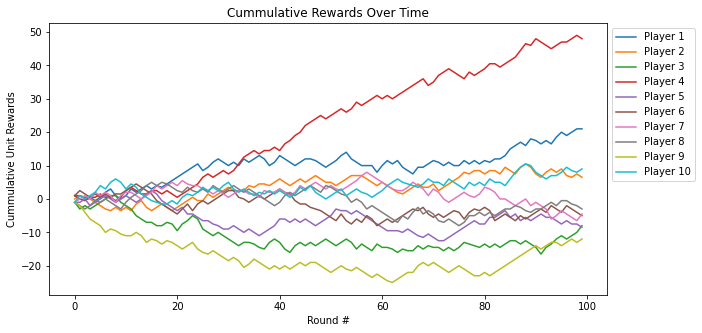

In [1580]:
rewards = await play_n_games(
    q=Qlearned,
    wagers=[1],
    n_rounds=100,
    n_games=10,
    game_hyperparams=game_hyperparams
)

plt.figure(figsize=(10,5))

for i,round in enumerate(np.cumsum(rewards, axis=2)[:,0,:]):
    plt.plot(round,label="Player {}".format(i+1))
plt.legend(bbox_to_anchor=[1, 1])
plt.title("Cummulative Rewards Over Time")
plt.xlabel("Round #")
plt.ylabel("Cummulative Unit Rewards")
plt.show()

### Give an example of playing a hand according to learned policy.

You can see the sequence of events taken by the player, the sequence of events taken by the house, the outcome, and the unit reward

In [1585]:
blackjack = Game(**game_hyperparams)

play_round(
    blackjack=blackjack,
    q=Qlearned,
    wagers=[1],
    verbose=True
)

Player Cards + Moves:
[[3, 10]] hit
[[3, 10, 5]] stay

House Cards
[[9, 3, 'A', 3, 'K']]

Result:


([['win']], [[1]])

## Evaluation

### First I can show the Value function

Two ways:
- Deterministic Action. Select best action. ie. P=1 for best action, else P=0
- Random Action. Best action is selected according to normalized q values

$V_{\pi}(s)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$
$$
V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]
$$

$Q_{\pi}(s,a)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$ and take action $a$
$$
Q_{\pi}(s,a) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right]
$$

We can relate $V$ and $Q$ by taking marginal expections over $a$

$$V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]$$

$$V_{\pi}(s) = E_a\left[E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right] \right]$$

$$V_{\pi}(s) = E_a\left[Q_{\pi}(s,a)\right]$$

$$V_{\pi}(s) = \sum_{a}\pi(s,a)Q(s,a)$$

Where $\pi(s,a)$ is the probability of taking action $a$ in state $s$

In reality, I"ll use:

$$V_s = max(Q(s,a))$$

In my case, I allow for randomization in action during Q learning. However, in evaluation, I always take the optimal action, which is deterministic

In practice, the action is taken that maximizes the Q value given the current state, deterministically.

In [699]:
Qlearned = np.load("./models/Q.npy",allow_pickle=True).item()

In [1603]:
fill = np.empty((3,21+1,11+1),dtype="O")
fill_accepted = np.empty((3,21+1,11+1),dtype="O")
value_det = np.zeros((3,21+1,11+1))

accepted_q = init_q(mode="accepted")

In [1605]:
max(v,key=v.get)

'split'

In [1588]:
# Deterministic. Pick best action

for k,v in Qlearned["no_split"].items() :
    p, h, a = k
    fill[int(a),p,h] = max(v,key=v.get)[:2].title()
    value_det[int(a),p,h] = max(v.values())

    v2 = accepted_q["no_split"][k]
    fill_accepted[int(a), p, h] = max(v2,key=v2.get)[:2].title()

for k,v in Qlearned["can_split"].items() :
    p,h,a = k
    if not isinstance(p,int) :
        p = 11
    fill[2,p,h] = max(v,key=v.get)[:2].title()
    value_det[2,p,h] = max(v.values())

    v2 = accepted_q["can_split"][k]
    fill_accepted[2, p, h] = max(v2,key=v2.get)[:2].title()

### Below I am plotting 3d visualizations of our Reward function.

#### We assume that the P=1 for taking the best action, and P=0 otherwise. We don"t learn transition probabilities in this model-free method, so we always take the best action in our environment

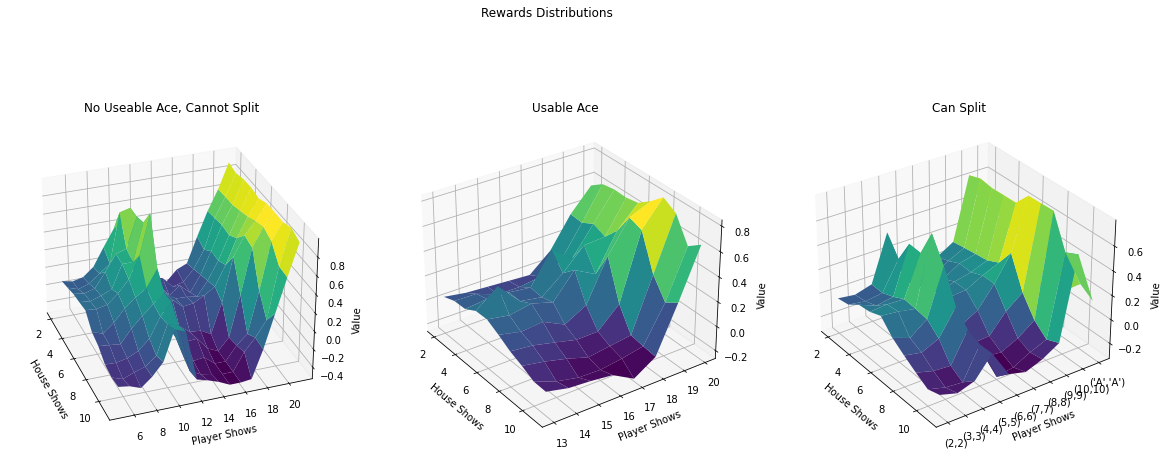

In [1589]:
fig = plt.figure(figsize=(20,8))
fig.suptitle("Rewards Distributions")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

noAceMesh = value_det[0][5:,2:]
x,y = np.meshgrid(range(2,12),range(5,22))
ax.plot_surface(x, y, noAceMesh, rstride=1, cstride=1,cmap="viridis", edgecolor="none")
ax.view_init(azim=-20)
ax.set_xlabel("House Shows")
ax.set_ylabel("Player Shows")
ax.set_zlabel("Value")

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace")
usableAceMesh = value_det[1][13:21,2:]
x,y = np.meshgrid(range(2,12),range(13,21))

ax.plot_surface(x, y, usableAceMesh, rstride=1, cstride=1,cmap="viridis", edgecolor="none")
ax.view_init(azim=-35)
ax.set_xlabel("House Shows")
ax.set_ylabel("Player Shows")
ax.set_zlabel("Value")

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

canSplitMesh = value_det[2][2:12,2:]
x,y = np.meshgrid(range(2,12),range(2,12))
ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
ax.set(yticks=range(2,12), yticklabels=ticks)
ax.plot_surface(x, y, canSplitMesh, rstride=1, cstride=1,cmap="viridis", edgecolor="none")
ax.view_init(azim=-35)
ax.set_xlabel("House Shows")
ax.set_ylabel("Player Shows")
ax.set_zlabel("Value")

plt.subplots_adjust(hspace=0, wspace=0.2)

plt.show()

In [1563]:
colorMap = {
    "St":"yellow",
    "Hi":"white",
    "Do":"green",
    "Su":"grey",
    "Sp":"blue"
}

In [1590]:
print("Accepted with No Useable Ace")
noAce = pd.DataFrame(fill_accepted[0])
noAce = noAce.iloc[5:][range(2,12)]\
    .style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
noAce

Accepted with No Useable Ace


,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
9,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Do
12,Hi,Hi,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi


In [1591]:
print("Learned with No Useable Ace")
noAce = pd.DataFrame(fill[0])
noAce = noAce.iloc[5:][range(2,12)]\
    .style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
noAce

Learned with No Useable Ace


,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi,Hi,Hi
9,Do,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Hi,Do,Do,Do
11,Do,Do,Do,Do,Do,Do,Do,Do,Hi,Do
12,St,St,St,Hi,St,Hi,Hi,Hi,Hi,Hi
13,Hi,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi


In [1592]:
print("Accepted with Useable Ace")
usableAce = pd.DataFrame(fill_accepted[1])
usableAce = usableAce.iloc[13:21][range(2,12)]\
    .style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
usableAce

Accepted with Useable Ace


,2,3,4,5,6,7,8,9,10,11
13,Hi,Hi,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Hi,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
18,Do,Do,Do,Do,Do,St,St,Hi,Hi,Hi
19,St,St,St,St,Do,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [1593]:
print("Learned with Useable Ace")
usableAce = pd.DataFrame(fill[1])
usableAce = usableAce.iloc[13:21][range(2,12)]\
    .style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
usableAce

Learned with Useable Ace


,2,3,4,5,6,7,8,9,10,11
13,Hi,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi,Hi
15,Hi,Hi,Do,Hi,Do,Hi,Hi,Hi,Hi,Hi
16,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi,Hi,Hi
17,Hi,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,Do,St,St,Do,St,St,St,Hi,Hi,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [1594]:
print("Accepted with Ability to Split")
canSplit = pd.DataFrame(fill_accepted[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ("A","A") for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
canSplit

Accepted with Ability to Split


,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(4, 4)",Hi,Hi,Hi,Sp,Sp,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi,Hi
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",Sp,Sp,Sp,Sp,Sp,St,Sp,Sp,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


In [1606]:
Qlearned["can_split"][(6,7,False)]

{'stay': -0.35097641462365636,
 'hit': -0.1846919238019662,
 'split': -0.09753384489858845,
 'double': -0.3113238630478247,
 'surrender': -0.36349520173602534}

In [1607]:
Qlearned["no_split"][(12,7,False)]

{'stay': -0.4945574084720041,
 'hit': -0.23838155525272814,
 'double': -0.42502091163275035,
 'surrender': -0.4999999999120584}

In [1595]:
print("Learned with Ability to Split")
canSplit = pd.DataFrame(fill[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ("A","A") for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
canSplit

Learned with Ability to Split


,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi
"(4, 4)",Hi,Sp,Hi,Sp,Sp,Hi,Hi,Sp,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,Sp,St,St,St,St,Sp,Sp,Sp,Sp
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Do,Sp,Sp,Sp,Sp,Sp


## I"m curious about frequency of busting as the house, on certain card totals

In [183]:
results = {}
busts = {}
player_results = {"soft":{},"hard":{}}

blackjack = Game(verbose=False)

for _ in range(1_000_000) :

    blackjack.init_round(wagers=[1])
    blackjack.deal_init()
    player = blackjack.players[0] # only 1 player, so i"ll just extract that specific player module.
    houseShow = blackjack.get_house_show(showValue=True)
    
    r_p = player._get_value_cards(player.cards[0])
    soft = r_p[1]
    if r_p[0] not in player_results["soft"] :
        player_results["soft"][r_p[0]] = {"n": 0, "rewards": 0}
        player_results["hard"][r_p[0]] = {"n": 0, "rewards": 0}

    if houseShow not in results :
        results[houseShow] = {"n": 0, "bust": 0, "17": 0, "18": 0, "19": 0, "20": 0,"21": 0}
    results[houseShow]["n"] += 1


    while not player.is_done() :

        playerShow,canSplit,useableAce,card1 = player.get_value()

        policy = player.get_valid_moves(houseShow)
        policy = [p for p in policy if p!="insurance"]
        if canSplit :
            move = get_best_action(Qlearned["can_split"][(card1,houseShow,useableAce)], policy, -1, "epsilon")
        else :
            move = get_best_action(Qlearned["no_split"][(playerShow,houseShow,useableAce)], policy, -1, "epsilon")

        blackjack.step_player(player,move)


    blackjack.step_house()
    
    total, _ = blackjack.house._get_value_cards(blackjack.house.cards[0])

    if total > 21 :
        results[houseShow]["bust"] += 1
        if total not in busts :
            busts[total] = 0
        busts[total] += 1
    if total <= 21 :
        results[houseShow][str(total)] += 1
        
    r_player = player.get_result(total,blackjack.house.cards)
    player_results["soft" if soft else "hard"][r_p[0]]["n"] += 1
    player_results["soft" if soft else "hard"][r_p[0]]["rewards"] += r_player[-1]
    
    

In [1570]:
print("Average Player Rewards Given Card Total at Draw")
for i in range(4, 22) :
    print(f"Card Total: {i}")
    if player_results["soft"][i]["n"] > 0 :
        print(f"\tSoft: {player_results['soft'][i]['rewards']/player_results['soft'][i]['n']}")
    else :
        print("\tSoft: NONE")
    if player_results["hard"][i]["n"] > 0 :
        print(f"\tHard: {player_results['hard'][i]['rewards']/player_results['hard'][i]['n']}")
    else :
        print("\tHard: NONE")

Average Player Rewards Given Card Total at Draw
Card Total: 4
	Soft: NONE
	Hard: -0.23479036574487064
Card Total: 5
	Soft: NONE
	Hard: -0.22772029372496663
Card Total: 6
	Soft: NONE
	Hard: -0.26030604088158044
Card Total: 7
	Soft: NONE
	Hard: -0.21280189157236953
Card Total: 8
	Soft: NONE
	Hard: -0.1320978452364819
Card Total: 9
	Soft: NONE
	Hard: 0.005063713761059485
Card Total: 10
	Soft: NONE
	Hard: 0.21184888931720716
Card Total: 11
	Soft: NONE
	Hard: 0.28719898605830163
Card Total: 12
	Soft: 0.4340668861549125
	Hard: -0.31078355139344355
Card Total: 13
	Soft: -0.030341023069207624
	Hard: -0.33477567201701797
Card Total: 14
	Soft: -0.04888507718696398
	Hard: -0.36895489005344534
Card Total: 15
	Soft: -0.08252106393523873
	Hard: -0.3853141559424678
Card Total: 16
	Soft: -0.09852746525479815
	Hard: -0.380886023613004
Card Total: 17
	Soft: -0.05655010875020913
	Hard: -0.2825907172995781
Card Total: 18
	Soft: 0.029080517734072952
	Hard: -0.02577085852478839
Card Total: 19
	Soft: 0.27274

In [1571]:
print("Probability of House Having a Value on Bust")
for i in range(22,27) :
    print(f"Total {i}: {100*busts[i]/sum(busts.values())}%")

Probability of House Having a Value on Bust
Total 22: 25.723919842060205%
Total 23: 23.014483638206055%
Total 24: 20.091199748414486%
Total 25: 17.16162622080123%
Total 26: 14.008770550518022%


In [1572]:
print("Probability of House Result")
out = []
for i in range(2,12) :
    inter = {}
    inter["Card Show"] = i
    for j in range(17,22) :
        inter[f"% {j}"] = 100*results[i][str(j)]/results[i]["n"]
    inter["% Bust"] = 100*results[i]["bust"]/results[i]["n"]
    out.append(inter)
              
pd.DataFrame(out)

Probability of House Result


,Card Show,% 17,% 18,% 19,% 20,% 21,% Bust
0,2,12.990531,13.626122,13.174175,12.702692,11.996770,35.509710
1,3,12.758647,13.248919,12.436947,12.115246,11.642989,37.797251
2,4,12.158126,12.650321,12.198384,11.751643,11.162048,40.079478
3,5,11.757579,12.239607,11.839654,11.321148,10.646309,42.195703
4,6,11.383963,11.468462,11.614061,11.126566,10.528574,43.878373
5,7,36.514825,13.809994,7.967154,7.956760,7.340904,26.410363
6,8,12.780839,35.856159,12.957970,7.065734,7.021451,24.317847
7,9,11.989972,11.782371,35.293580,12.151876,6.067451,22.714750
8,10,11.143448,11.205557,11.169137,34.011108,11.225392,21.245358
9,11,5.548048,14.466504,14.172860,14.198846,37.563016,14.050725


## Next, I want to incorporate "card count" into the model. This makes the space too large. The solution to this is approximating the Q learning function, through deep learning methods.